
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

NOTE: there are some errors in the last part of this notebook from the given code. I am not sure why they didn't work, so I didn't rerun them. No errors with my code though.

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).


# ***What?*** 
<200 words

I am interested in studying the content and how information operations (IOs) in Thailand operate on a social media platform. There are 2 objectives of my final project. First, Thai netizens have come up with some observations to detect users that are suspected to be a part of a wider information operations carried out by the government and the militrary. I am curious to see if I can come up with a good classification scheme to classify these users based on the content of their posts and meta data that I can obtain. Second, I would like to build a network of these users and see how they interact with non-IOs users. The plan is to collect data on users, hashtags, contents, and posts from Twitter. The reason I chose Twitter is because it is the second most popular social media platform in Thailand.


## ***Why?***
<200 words

Various scholarly works attempt to systematically study censorship. A recent work, *Censored: Distraction and Diversion Inside China's Great Firewall*, by Margaret E. Roberts stands out. In her book, Roberts proposes that there are three mechanisms of censorship–all with the objective of slowing the flow of information. Flooding which is one of the mechanisms is what I am interested in. It is difficult to prove flooding because it is usually a secret operation. However, due to recent social media activities in Thailand, there is evidence of flooding in the form of "astroturfing." Studying this activity can enhance our understanding about how censorship works on social media platforms. What puzzles me is that the Thai government did not carry out a successful covert information operations at all because Thai Twitter users detected such activities at a very early stage twice. Why do governments do it? Another potential benefit from this research project is to get a good understanding of users on Twitter in Thailand. During important political events, is Twitter full of these information operations accounts? How do netizens combat them more effectively?     


## ***How?***
<400 words

My plan to fulfill the 2 objectives laid out in the aforementioned part is as follows: 

1. collect users data and their posts on Twitter, both suspected information operation accounts and normal users' accounts, between February 5 to February 15, 2020 with hashtag #รัฐบาลเตรียมพร้อม (literal translation: The government is ready). Randomly draw a sample of 200 accounts and use human coder(s) to label these accounts. Randomly split the rest of the data into training and test sets and use machine learning models to train a classifier to classify users. 
2. collect more user data keyworded by hashtags from a past political event, tentatively the Thai general election on March 24, 2019, and use the classifier I have from part (1) to classify users.
3. Randomly draw a sample of suspected IOs accounts and conduct text analysis on their posts to see what kind of content these users engage in. I plan to use topic modeling here because hand classification is going to be too costly.
4. Build a network of followers and following of these accounts using the methods I learned in this class. I am also interested in a community detection algorithm on the data that I have. The main question here is if we can conclude anything about their network like these users do not follow each other, but they follow certain governmental organizations. This is a direct test to Thai netizens' theory of classifying IOs accounts.


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).


## ***Which (words)?***

The rationale behind the proposed research project is many folds. Firstly, I want to leverage techniques that I learned in this class to conduct a research on a topic of my interest. Secondly, the research result, I believe, will also benefit our current understandings about flooding. The social game being played here is quite interesting because it is a direct interaction between the government and the people. A large number of Twitter users in Thailand are known to be progressive and critical of the government. Therefore, it is not surprising that the government has to plan an information operation to make sure that they can control the platform. However, what is even more interesting is that Twitter users act in unity to outsmart the government and they have been quite successful in doing so. 

The main limitation of this research project is the lack of ground truth. Unlike a study on China's 50 cents party by King, Pan and Roberts (2017), I do not have the luxury of leaked documents which confirm the existance of information operations or these accounts. What I only have is the observations from Thai Twitter users that some acounts are suspicious. Hence, my analysis may not be 100% accurate. I am not sure what is a better alternative to conduct this research.

A reasonable path to scale up my research project is my thesis writing. This project will serves as a core analysis of my MA thesis. If it turns out to be a successful project, I would like to send it to conferences. 

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [3]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [4]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [5]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [6]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [7]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [8]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [9]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [10]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [11]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [12]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [13]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [14]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [15]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [16]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [17]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [18]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'check_scoring', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_arg

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [19]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0


We can also look at the distinguishing features in each cluster:

In [20]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 thanks
 mac
 just
 does
 drive
 like
 apple
 don
 new


Cluster 1:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 dealer


Cluster 2:
 window
 server
 use
 motif
 using
 widget
 program
 application
 like
 code


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [21]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [22]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [23]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

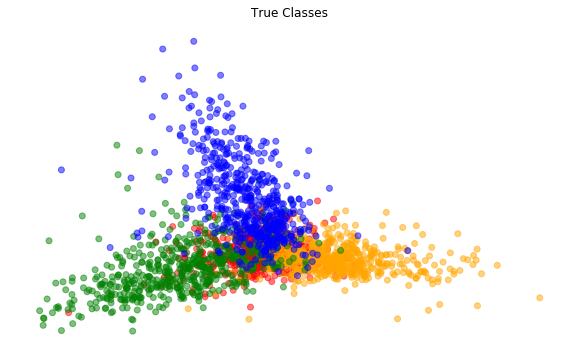

In [24]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

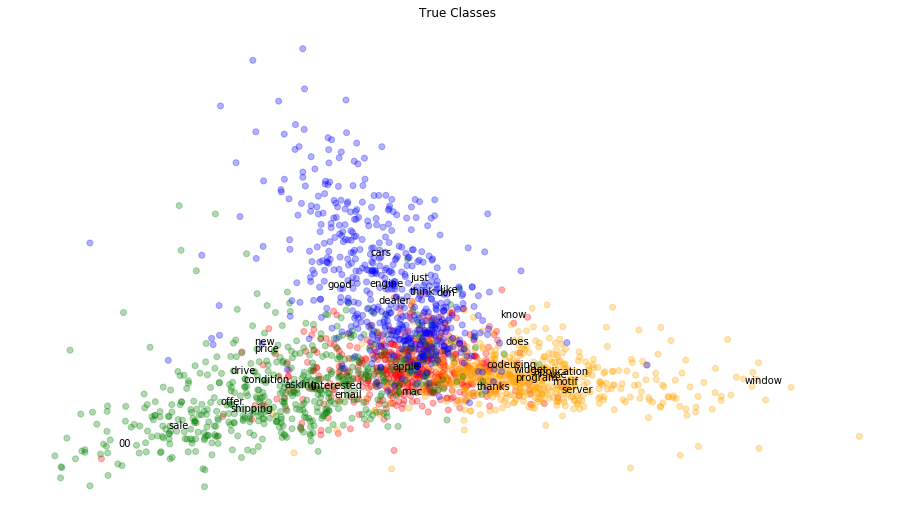

In [25]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [26]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

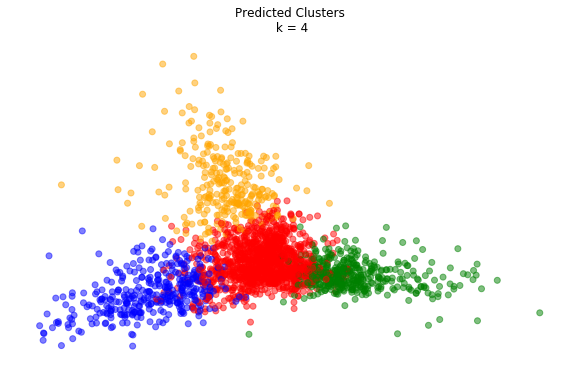

In [27]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [28]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [29]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


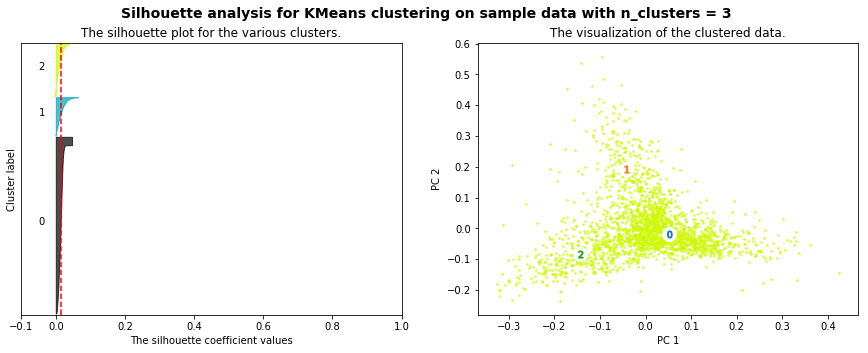

For n_clusters = 3, The average silhouette_score is : 0.014


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


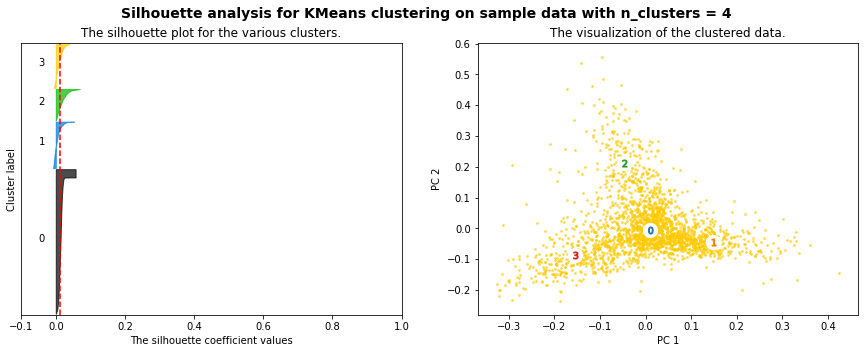

For n_clusters = 4, The average silhouette_score is : 0.012


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


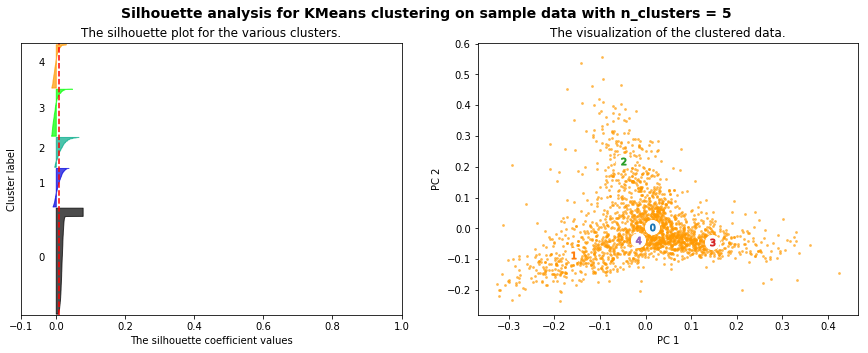

For n_clusters = 5, The average silhouette_score is : 0.010


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


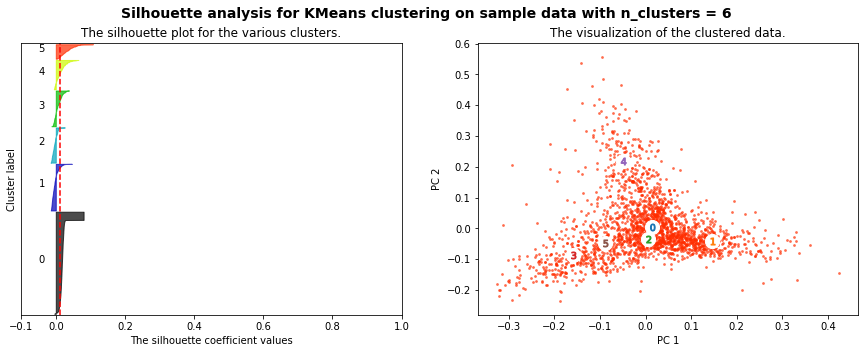

For n_clusters = 6, The average silhouette_score is : 0.011


In [33]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [34]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [35]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [36]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [37]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [38]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [39]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize:

In [40]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

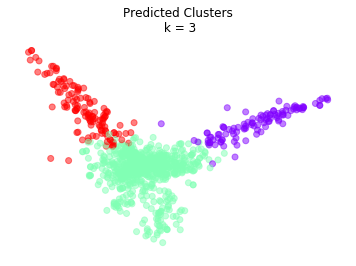

In [41]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [42]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,2
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,2


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [51]:
# using the inaugural presidential speeches again
# load data set
speeches = pandas.read_csv("./data/inaug_speeches.csv")
# get it in a dataframe 
speeches.head()

,name,inaug_party,elected,term,inaugural_address,day_of_week,month_day,speech_year,text
0,George Washington,nonaffiliated,1,1,1,Thursday,April 30,1789,Fellow-Citizens of the Senate and o...
1,George Washington,nonaffiliated,1,2,2,Monday,March 4,1793,Fellow Citizens: I AM again cal...
2,John Adams,Federalist,1,1,1,Saturday,March 4,1797,"WHEN it was first perceived, in ..."
3,Thomas Jefferson,Democratic-Republican,1,1,1,Wednesday,March 4,1801,Friends and Fellow-Citizens: CA...
4,Thomas Jefferson,Democratic-Republican,1,2,2,Monday,March 4,1805,"PROCEEDING, fellow-citizens, to ..."


In [52]:
def clean_text(text):
    '''customize function to clean text'''
    clean_text = text.replace("\xa0", "").replace("<U+0097>", "").replace("<u+0092>", "").replace("<U+0092>", "")
    clean_text = clean_text.strip()
    clean_text = clean_text.lower()
    return clean_text

In [53]:
# clean the text before tokenization and normalization
speeches['clean_text'] = speeches['text'].apply(lambda x: clean_text(x))

# tokenize and normalize texts
speeches['tokenized_sents'] = speeches['clean_text'].apply(
    lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])

speeches['normalized_sents'] = speeches['tokenized_sents'].apply(
    lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [54]:
speeches.head()

,name,inaug_party,elected,term,inaugural_address,day_of_week,month_day,speech_year,text,clean_text,tokenized_sents,normalized_sents
0,George Washington,nonaffiliated,1,1,1,Thursday,April 30,1789,Fellow-Citizens of the Senate and o...,fellow-citizens of the senate and of the house...,"[[fellow, citizens, of, the, senate, and, of, ...","[[fellow, citizen, senate, house, representati..."
1,George Washington,nonaffiliated,1,2,2,Monday,March 4,1793,Fellow Citizens: I AM again cal...,fellow citizens: i am again called upon by th...,"[[fellow, citizens], [i, am, again, called, up...","[[fellow, citizen], [call, voice, country, exe..."
2,John Adams,Federalist,1,1,1,Saturday,March 4,1797,"WHEN it was first perceived, in ...","when it was first perceived, in early times, t...","[[when, it, was, first, perceived, in, early, ...","[[perceive, early, time, middle, course, ameri..."
3,Thomas Jefferson,Democratic-Republican,1,1,1,Wednesday,March 4,1801,Friends and Fellow-Citizens: CA...,friends and fellow-citizens: called upon to u...,"[[friends, and, fellow, citizens, called, upon...","[[friend, fellow, citizen, call, undertake, du..."
4,Thomas Jefferson,Democratic-Republican,1,2,2,Monday,March 4,1805,"PROCEEDING, fellow-citizens, to ...","proceeding, fellow-citizens, to that qualifica...","[[proceeding, fellow, citizens, to, that, qual...","[[proceed, fellow, citizen, qualification, con..."


In [55]:
# create word-document matrix
spTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_df=100, min_df=2, max_features=1000, stop_words='english', norm='l2')
spTFVects = spTFVectorizer.fit_transform(speeches['clean_text'])

This first thing to do is to select the number of clusters. Since my data lacks the ground truth (no labels), I use avergae silouette score to determine the optimal number of clusters.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


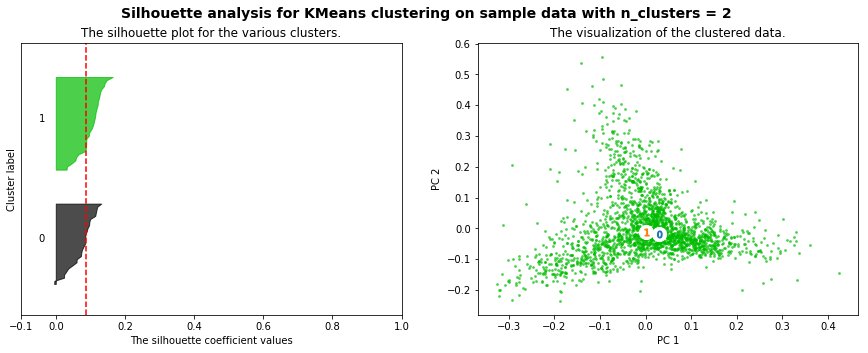

For n_clusters = 2, The average silhouette_score is : 0.089


In [99]:
# identify the optimal number of cluster with Silhouette analysis
# based on what we know so far about inaugural addreses from past week analysis
# there might not be a lot of clusters in the data
# try 2, 3, 4 and 5 and compare

# 2 clusters
plotSilhouette(2, spTFVects.toarray())

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


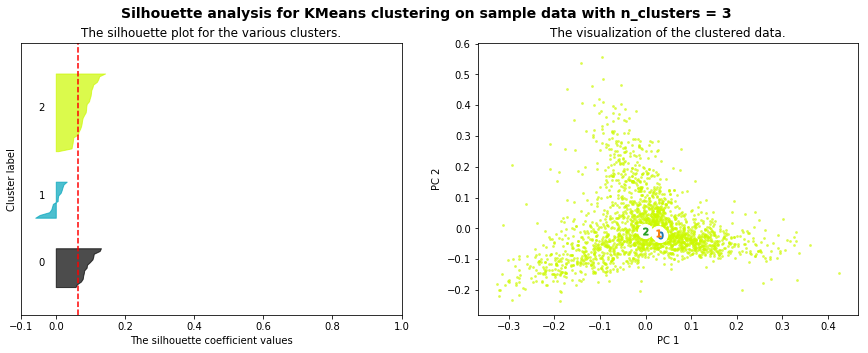

For n_clusters = 3, The average silhouette_score is : 0.065


In [100]:
# 3 clusters
plotSilhouette(3, spTFVects.toarray())

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


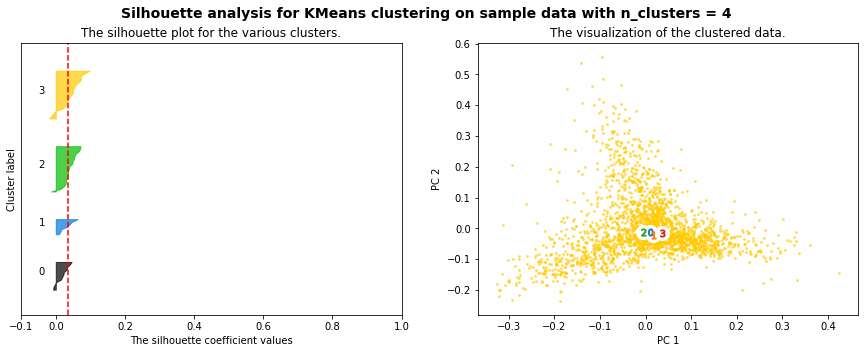

For n_clusters = 4, The average silhouette_score is : 0.035


In [101]:
# 4 clusters
plotSilhouette(4, spTFVects.toarray())

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


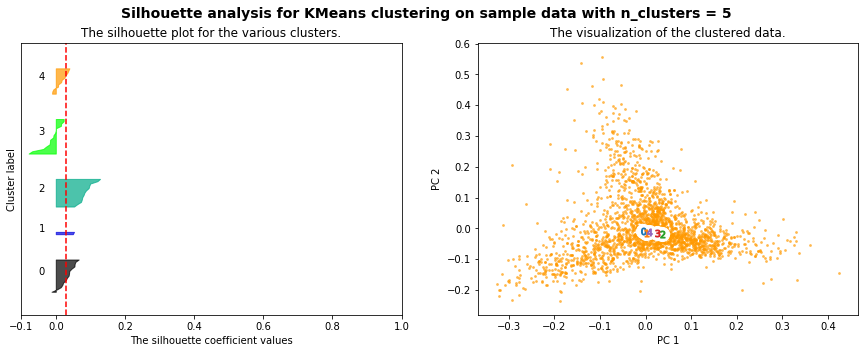

For n_clusters = 5, The average silhouette_score is : 0.029


In [102]:
# 5 clusters
plotSilhouette(5, spTFVects.toarray())

Based on the inaugural speeches data set, the best number of clusters appear to be 2. However, it should be noted that, even at 2, the average sillouette score is very low, totaling only 0.089. Since the average silouette score ranges from -1 to +1, our score is much further away from +1. For the sake of this assignment, I pick 2 as the number of clusters to iterrogate the content and visualize. 

In [113]:
# K-means model with 2 as the number of clusters
km = sklearn.cluster.KMeans(n_clusters=2, init='k-means++')
km.fit(spTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [114]:
# use provided function to check the content of each cluster
# for each, check for content of cluster
spterms = spTFVectorizer.get_feature_names()
print("Top terms per cluster:")
sp_order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(2):
    print("Cluster %d:" % i)
    for ind in sp_order_centroids[i, :10]:
        print(' %s' % spterms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 government
 people
 states
 public
 country
 shall
 constitution
 union
 great
 citizens


Cluster 1:
 world
 america
 nation
 people
 new
 freedom
 let
 today
 peace
 government




As expected, the 2 clusters barely differ. It suggests that the inaugral speeches are quite homogenous across presidency.

In [119]:
# PCA for visualization
PCA = sklearn.decomposition.PCA
pca = PCA(n_components=2).fit(spTFVects.toarray())
reduced_data = pca.transform(spTFVects.toarray())

components = pca.components_
sp_keyword_ids = list(set(sp_order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [spterms[i] for i in sp_keyword_ids]#Turn the ids into words.
x = components[:, sp_keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:, sp_keyword_ids][1,:]

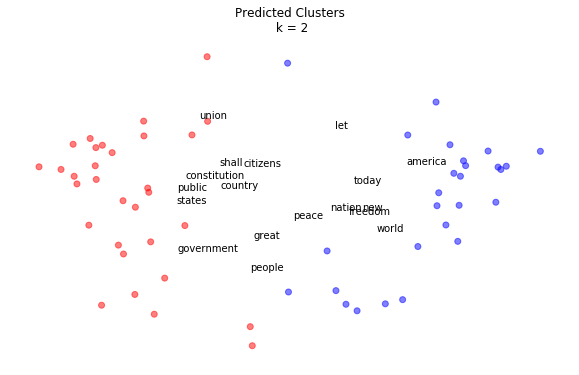

In [120]:
colordict = {
'0': 'red',
'1': 'blue',
    }

# plot for predicted clusters
colors_p = [colordict[str(lab)] for lab in km.labels_]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha=0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 2')
plt.show()

__Discussion:__ What does this cluster structure reveal about the organization of documents in your corpora?

Unfortunately, the cluster structure does not reveal much about the organization of documents in the corpora. I think this is because the documents are too silimar to each other. As mentioned before, this suggests that presidential inaugural addresses are very similar across presidents.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [43]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [44]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [45]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/sanittawan/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [46]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [47]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [48]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[143.        , 145.        ,   0.        ,   2.        ],
       [148.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [119.        , 154.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        , 112.        ,   0.45096656,   2.        ],
       [101.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

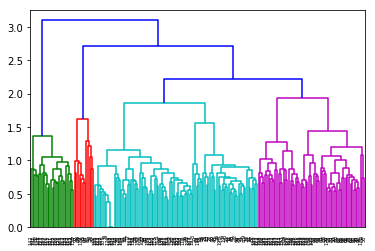

In [49]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

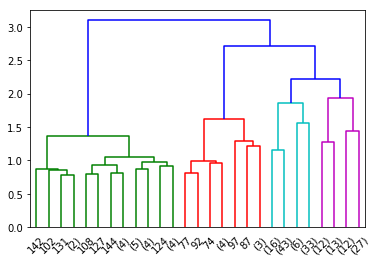

In [50]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [51]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2,
       3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [52]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [53]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,3
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [54]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

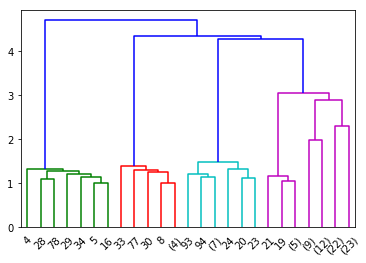

In [55]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [56]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [122]:
# calculate the co-occurrence matrix
spCoocMat = spTFVects * spTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
spCoocMat.setdiag(0)
spCoocMat

<58x58 sparse matrix of type '<class 'numpy.float64'>'
	with 3364 stored elements in Compressed Sparse Row format>

In [123]:
# Hierachical clustering
# first approach (based on Ward's method)
sp_linkage_matrix = scipy.cluster.hierarchy.ward(spCoocMat.toarray())
sp_linkage_matrix[:10]

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[29.        , 36.        ,  0.47772166,  2.        ],
       [ 6.        , 20.        ,  0.51940384,  2.        ],
       [ 4.        , 21.        ,  0.53081566,  2.        ],
       [31.        , 58.        ,  0.53376304,  3.        ],
       [44.        , 46.        ,  0.53983208,  2.        ],
       [47.        , 57.        ,  0.55214141,  2.        ],
       [ 0.        , 10.        ,  0.55237385,  2.        ],
       [38.        , 43.        ,  0.55313565,  2.        ],
       [11.        , 15.        ,  0.5824963 ,  2.        ],
       [30.        , 60.        ,  0.59652349,  3.        ]])

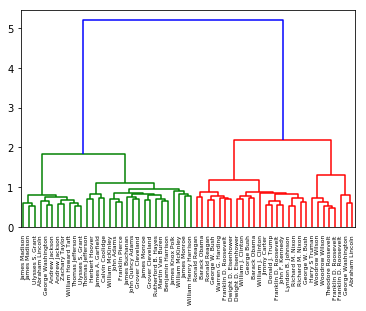

In [130]:
sp_dendDat = scipy.cluster.hierarchy.dendrogram(sp_linkage_matrix, get_leaves=True, labels=speeches['name'].tolist())

It looks like there are 2 main clusters. The clusters tend to differentiate between more contemporary and ealier presidents.

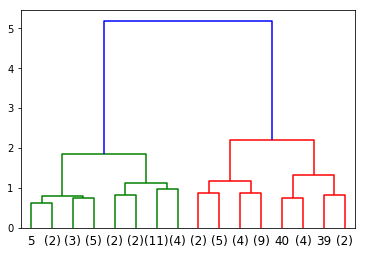

In [152]:
# prune the clusters 
# select 3 levels
dendrogramDat = scipy.cluster.hierarchy.dendrogram(sp_linkage_matrix, p=3, 
                                                   truncate_mode='level', get_leaves=True)

In [126]:
# Hierachical clustering
# second approach (break trees into pre-determined number of clusters)
sp_fclust = scipy.cluster.hierarchy.fcluster(sp_linkage_matrix, 2, 'maxclust')
sp_fclust

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [134]:
speeches['f_clust_pred'] = sp_fclust

In [150]:
speeches[speeches['f_clust_pred'] == 1]

,name,inaug_party,elected,term,inaugural_address,day_of_week,month_day,speech_year,text,clean_text,tokenized_sents,normalized_sents,f_clust_pred
0,George Washington,nonaffiliated,1,1,1,Thursday,April 30,1789,Fellow-Citizens of the Senate and o...,fellow-citizens of the senate and of the house...,"[[fellow, citizens, of, the, senate, and, of, ...","[[fellow, citizen, senate, house, representati...",1
2,John Adams,Federalist,1,1,1,Saturday,March 4,1797,"WHEN it was first perceived, in ...","when it was first perceived, in early times, t...","[[when, it, was, first, perceived, in, early, ...","[[perceive, early, time, middle, course, ameri...",1
3,Thomas Jefferson,Democratic-Republican,1,1,1,Wednesday,March 4,1801,Friends and Fellow-Citizens: CA...,friends and fellow-citizens: called upon to u...,"[[friends, and, fellow, citizens, called, upon...","[[friend, fellow, citizen, call, undertake, du...",1
4,Thomas Jefferson,Democratic-Republican,1,2,2,Monday,March 4,1805,"PROCEEDING, fellow-citizens, to ...","proceeding, fellow-citizens, to that qualifica...","[[proceeding, fellow, citizens, to, that, qual...","[[proceed, fellow, citizen, qualification, con...",1
5,James Madison,Democratic-Republican,1,1,1,Saturday,March 4,1809,UNWILLING to depart from example...,unwilling to depart from examples of the most ...,"[[unwilling, to, depart, from, examples, of, t...","[[unwilling, depart, example, revere, authorit...",1
6,James Madison,Democratic-Republican,1,2,2,Thursday,March 4,1813,ABOUT to add the solemnity of an...,about to add the solemnity of an oath to the o...,"[[about, to, add, the, solemnity, of, an, oath...","[[add, solemnity, oath, obligation, impose, 2,...",1
7,James Monroe,Democratic-Republican,1,1,1,Tuesday,March 4,1817,I SHOULD be destitute of feeling...,i should be destitute of feeling if i was not ...,"[[i, should, be, destitute, of, feeling, if, i...","[[destitute, feel, deeply, affect, strong, pro...",1
8,James Monroe,Democratic-Republican,1,2,2,Monday,March 5,1821,Fellow-Citizens: I SHALL not at...,fellow-citizens: i shall not attempt to descr...,"[[fellow, citizens, i, shall, not, attempt, to...","[[fellow, citizen, shall, attempt, describe, g...",1
9,John Quincy Adams,Democratic-Republican,1,1,1,Friday,March 4,1825,IN compliance with an usage coev...,in compliance with an usage coeval with the ex...,"[[in, compliance, with, an, usage, coeval, wit...","[[compliance, usage, coeval, existence, federa...",1
10,Andrew Jackson,Democratic,1,1,1,Wednesday,March 4,1829,Fellow-Citizens: ABOUT to under...,fellow-citizens: about to undertake the arduo...,"[[fellow, citizens, about, to, undertake, the,...","[[fellow, citizen, undertake, arduous, duty, a...",1


In [149]:
speeches[speeches['f_clust_pred'] == 2]

,name,inaug_party,elected,term,inaugural_address,day_of_week,month_day,speech_year,text,clean_text,tokenized_sents,normalized_sents,f_clust_pred
1,George Washington,nonaffiliated,1,2,2,Monday,March 4,1793,Fellow Citizens: I AM again cal...,fellow citizens: i am again called upon by th...,"[[fellow, citizens], [i, am, again, called, up...","[[fellow, citizen], [call, voice, country, exe...",2
19,Abraham Lincoln,Republican,1,2,2,Saturday,March 4,1865,Fellow-Countrymen: AT this se...,fellow-countrymen: at this second appearing...,"[[fellow, countrymen, at, this, second, appear...","[[fellow, countryman, 2, appear, oath, preside...",2
29,Theodore Roosevelt,Republican,1,2,1,Saturday,March 4,1905,"MY fellow-citizens, no people on...","my fellow-citizens, no people on earth have mo...","[[my, fellow, citizens, no, people, on, earth,...","[[fellow, citizen, people, earth, cause, thank...",2
31,Woodrow Wilson,Democratic,1,1,1,Tuesday,March 4,1913,THERE has been a change of gover...,there has been a change of government. it bega...,"[[there, has, been, a, change, of, government]...","[[change, government], [begin, year, ago, hous...",2
32,Woodrow Wilson,Democratic,1,2,2,Monday,March 5,1917,My Fellow Citizens: THE four ye...,my fellow citizens: the four years which have...,"[[my, fellow, citizens, the, four, years, whic...","[[fellow, citizen, year, elapse], [stand, plac...",2
33,Warren G. Harding,Republican,1,1,1,Friday,March 4,1921,My Countrymen: WHEN one surveys...,my countrymen: when one surveys the world abo...,"[[my, countrymen], [when, one, surveys, the, w...","[[countryman], [survey, world, great, storm, n...",2
36,Franklin D. Roosevelt,Democratic,1,1,1,Saturday,March 4,1933,I AM certain that my fellow Amer...,i am certain that my fellow americans expect t...,"[[i, am, certain, that, my, fellow, americans,...","[[certain, fellow, americans, expect, inductio...",2
37,Franklin D. Roosevelt,Democratic,1,2,2,Wednesday,January 20,1937,WHEN four years ago we met to in...,when four years ago we met to inaugurate a pre...,"[[when, four, years, ago, we, met, to, inaugur...","[[year, ago, meet, inaugurate, president, repu...",2
38,Franklin D. Roosevelt,Democratic,1,3,3,Monday,January 20,1941,ON each national day of inaugura...,on each national day of inauguration since ...,"[[on, each, national, day, of, inauguration, s...","[[national, day, inauguration, people, renew, ...",2
39,Franklin D. Roosevelt,Democratic,1,4,4,Saturday,January 20,1945,"MR. Chief Justice, Mr. Vice Pres...","mr. chief justice, mr. vice president, my frie...","[[mr, chief, justice, mr, vice, president, my,...","[[mr, chief, justice, mr, vice, president, fri...",2


In [148]:
# number of presidents in each group
speeches['f_clust_pred'].value_counts()

1    30
2    28
Name: f_clust_pred, dtype: int64

When looking at the clustering result, the main distinction appears to be more recent vs. earlier presidents.

In [151]:
# lack ground truth 
# use Silhouette method to evaluate
sklearn.metrics.silhouette_score(spCoocMat, sp_fclust, metric='euclidean')

0.3372513749256497

Based on the Silhoette score, hierachical clustering tends to perform better than k-means.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [57]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [58]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [58]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

NameError: name 'senReleasesTraining' is not defined

In [60]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [61]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [62]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [63]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [64]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(7, 0.97363263)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [65]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [66]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(4, 0.97142816)]",0.000000,0.000000,0.0,0.000000,0.971428,0.000000,0.000000,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(1, 0.13308884), (8, 0.16936573), (9, 0.68771...",0.000000,0.133089,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.169366,0.687713
201,04May2006Kennedy8.txt,"[(7, 0.5466249), (8, 0.104917206), (9, 0.34417...",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.546625,0.104917,0.344174
301,06Jun2007Kennedy1.txt,"[(0, 0.23052813), (3, 0.29048118), (4, 0.23681...",0.230528,0.000000,0.0,0.290481,0.236815,0.119113,0.000000,0.121929,0.000000,0.000000
401,08Feb2005Kennedy0.txt,"[(1, 0.3524812), (3, 0.6416813)]",0.000000,0.352481,0.0,0.641681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(5, 0.36707053), (8, 0.59422094)]",0.000000,0.000000,0.0,0.000000,0.000000,0.367071,0.000000,0.000000,0.594221,0.000000
601,11Nov2005Kennedy6.txt,"[(6, 0.97200537)]",0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.972005,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(0, 0.6348284), (7, 0.03282224), (9, 0.3300591)]",0.634828,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.032822,0.000000,0.330059
801,15Dec2005Kennedy5.txt,"[(3, 0.59574383), (5, 0.13790782), (7, 0.02353...",0.000000,0.000000,0.0,0.595744,0.000000,0.137908,0.000000,0.023539,0.241670,0.000000
901,16May2007Kennedy5.txt,"[(3, 0.6934802), (4, 0.17440249), (7, 0.096590...",0.000000,0.000000,0.0,0.693480,0.174402,0.000000,0.000000,0.096591,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [67]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.973630,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.971428,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.107515,0.000000,0.699158,0.000000,0.000000,0.187858,0.0,0.000000
3,0.527152,0.000000,0.000000,0.000000,0.000000,0.000000,0.115043,0.000000,0.0,0.353072
4,0.000000,0.000000,0.034453,0.094414,0.000000,0.814338,0.000000,0.055292,0.0,0.000000
5,0.000000,0.000000,0.721689,0.000000,0.000000,0.270702,0.000000,0.000000,0.0,0.000000
6,0.249288,0.000000,0.000000,0.000000,0.000000,0.000000,0.588328,0.000000,0.0,0.154164
7,0.000000,0.000000,0.000000,0.000000,0.967255,0.000000,0.000000,0.000000,0.0,0.000000
8,0.000000,0.423729,0.033800,0.000000,0.451694,0.000000,0.000000,0.087441,0.0,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.967270,0.000000,0.000000,0.000000,0.0,0.000000


First we can visualize as a stacked bar chart:

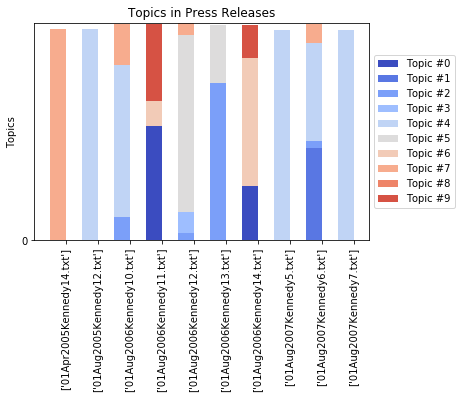

In [68]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

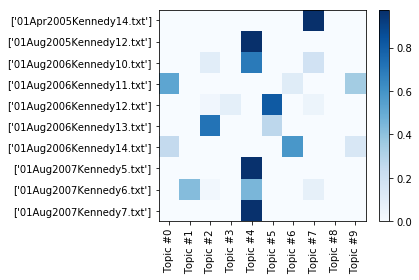

In [69]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [70]:
senlda.show_topic(1)

[('fund', 0.007635647),
 ('head', 0.0053224484),
 ('teacher', 0.0043220418),
 ('project', 0.0043004216),
 ('assessment', 0.0040812297),
 ('unite', 0.0036947024),
 ('science', 0.003409662),
 ('development', 0.0034050557),
 ('standard', 0.00326883),
 ('propose', 0.0031874191)]

And if we want to make a dataFrame:

In [71]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,worker,fund,worker,worker,loan,worker,wage,worker,fund,intelligence
1,fund,head,wage,head,lender,fund,minimum,loan,worker,troop
2,pension,teacher,minimum,fund,fund,wage,worker,fund,medicaid,unite
3,company,project,fund,teacher,worker,asbestos,fda,immigrant,medicare,patient
4,loan,assessment,loan,train,pension,minimum,fund,parent,unite,fund
5,aid,unite,lender,immigration,rate,victim,iraqi,immigration,senior,fda
6,retirement,science,company,follow,company,trust,troop,hear,immigration,test
7,judge,development,medicare,judge,unite,company,woman,rate,teacher,soldier
8,unite,standard,judge,immigrant,woman,compensation,head,unite,insurance,concern
9,immigration,propose,bankruptcy,company,wage,immigration,bankruptcy,aid,head,hear


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

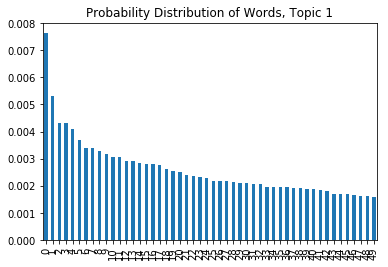

In [72]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [73]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

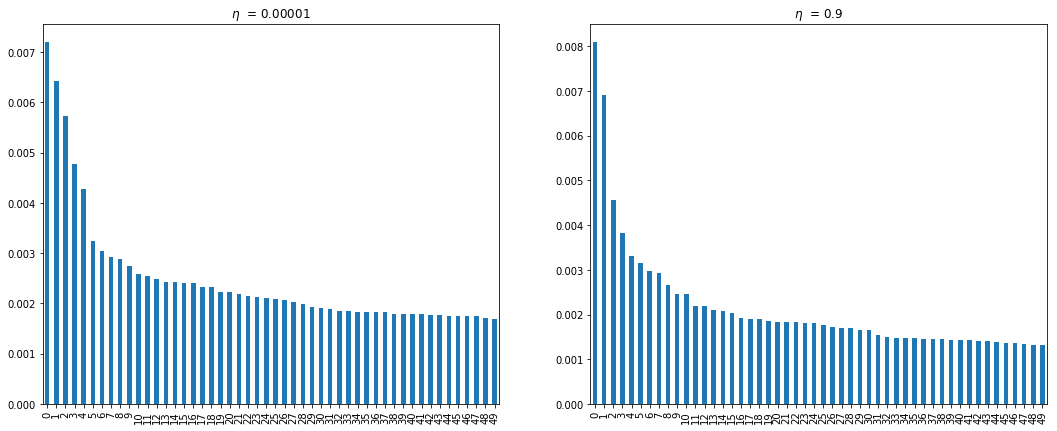

In [74]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [56]:
speeches.head()

,name,inaug_party,elected,term,inaugural_address,day_of_week,month_day,speech_year,text,clean_text,tokenized_sents,normalized_sents
0,George Washington,nonaffiliated,1,1,1,Thursday,April 30,1789,Fellow-Citizens of the Senate and o...,fellow-citizens of the senate and of the house...,"[[fellow, citizens, of, the, senate, and, of, ...","[[fellow, citizen, senate, house, representati..."
1,George Washington,nonaffiliated,1,2,2,Monday,March 4,1793,Fellow Citizens: I AM again cal...,fellow citizens: i am again called upon by th...,"[[fellow, citizens], [i, am, again, called, up...","[[fellow, citizen], [call, voice, country, exe..."
2,John Adams,Federalist,1,1,1,Saturday,March 4,1797,"WHEN it was first perceived, in ...","when it was first perceived, in early times, t...","[[when, it, was, first, perceived, in, early, ...","[[perceive, early, time, middle, course, ameri..."
3,Thomas Jefferson,Democratic-Republican,1,1,1,Wednesday,March 4,1801,Friends and Fellow-Citizens: CA...,friends and fellow-citizens: called upon to u...,"[[friends, and, fellow, citizens, called, upon...","[[friend, fellow, citizen, call, undertake, du..."
4,Thomas Jefferson,Democratic-Republican,1,2,2,Monday,March 4,1805,"PROCEEDING, fellow-citizens, to ...","proceeding, fellow-citizens, to that qualifica...","[[proceeding, fellow, citizens, to, that, qual...","[[proceed, fellow, citizen, qualification, con..."


In [59]:
# prepare data by reducing the tokenized words

speeches['tokenized_text'] = speeches['clean_text'].apply(
    lambda x: lucem_illud_2020.word_tokenize(x))
speeches['normalized_tokens'] = speeches['tokenized_text'].apply(
    lambda x: lucem_illud_2020.normalizeTokens(x))

speeches['reduced_tokens'] = speeches['normalized_tokens'].apply(
    lambda x: dropMissing(x, spTFVectorizer.vocabulary_.keys()))

In [60]:
# check
speeches.head()

,name,inaug_party,elected,term,inaugural_address,day_of_week,month_day,speech_year,text,clean_text,tokenized_sents,normalized_sents,tokenized_text,normalized_tokens,reduced_tokens
0,George Washington,nonaffiliated,1,1,1,Thursday,April 30,1789,Fellow-Citizens of the Senate and o...,fellow-citizens of the senate and of the house...,"[[fellow, citizens, of, the, senate, and, of, ...","[[fellow, citizen, senate, house, representati...","[fellow, citizens, of, the, senate, and, of, t...","[fellow, citizen, senate, house, representativ...","[fellow, citizen, senate, life, event, great, ..."
1,George Washington,nonaffiliated,1,2,2,Monday,March 4,1793,Fellow Citizens: I AM again cal...,fellow citizens: i am again called upon by th...,"[[fellow, citizens], [i, am, again, called, up...","[[fellow, citizen], [call, voice, country, exe...","[fellow, citizens, i, am, again, called, upon,...","[fellow, citizen, call, voice, country, execut...","[fellow, citizen, voice, country, execute, chi..."
2,John Adams,Federalist,1,1,1,Saturday,March 4,1797,"WHEN it was first perceived, in ...","when it was first perceived, in early times, t...","[[when, it, was, first, perceived, in, early, ...","[[perceive, early, time, middle, course, ameri...","[when, it, was, first, perceived, in, early, t...","[perceive, early, time, middle, course, americ...","[early, time, course, america, remain, foreign..."
3,Thomas Jefferson,Democratic-Republican,1,1,1,Wednesday,March 4,1801,Friends and Fellow-Citizens: CA...,friends and fellow-citizens: called upon to u...,"[[friends, and, fellow, citizens, called, upon...","[[friend, fellow, citizen, call, undertake, du...","[friends, and, fellow, citizens, called, upon,...","[friend, fellow, citizen, call, undertake, dut...","[friend, fellow, citizen, duty, executive, off..."
4,Thomas Jefferson,Democratic-Republican,1,2,2,Monday,March 4,1805,"PROCEEDING, fellow-citizens, to ...","proceeding, fellow-citizens, to that qualifica...","[[proceeding, fellow, citizens, to, that, qual...","[[proceed, fellow, citizen, qualification, con...","[proceeding, fellow, citizens, to, that, quali...","[proceed, fellow, citizen, qualification, cons...","[fellow, citizen, constitution, require, duty,..."


In [61]:
# generate dictionary
sp_dictionary = gensim.corpora.Dictionary(speeches['reduced_tokens'])

# create list of tuples with words and counts
sp_corpus = [sp_dictionary.doc2bow(text) for text in speeches['reduced_tokens']]

# turn the corpus into a file and load it
gensim.corpora.MmCorpus.serialize('speeches.mm', sp_corpus)
speechesmm = gensim.corpora.MmCorpus('speeches.mm')

In [62]:
def fit_LDA(df, corpus, dictionary, num_topics, a, h):
    '''customize function to fit an LDA model and create DF'''
    # fit LDA model
    speeches_lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                               num_topics=num_topics, alpha=a, eta=h)
    
    # generate dataframe
    sp_ldaDF = pandas.DataFrame({
        'name' : df['name'],
        'topics' : [speeches_lda[dictionary.doc2bow(l)] for l in df['reduced_tokens']]
    })
    
    # Dict to temporally hold the probabilities
    sp_topicsProbDict = {i : [0] * len(sp_ldaDF) for i in range(speeches_lda.num_topics)}

    # Load them into the dict
    for index, topicTuples in enumerate(sp_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            sp_topicsProbDict[topicNum][index] = prob

    # Update the DataFrame
    for topicNum in range(speeches_lda.num_topics):
        sp_ldaDF['topic_{}'.format(topicNum)] = sp_topicsProbDict[topicNum]
    
    return speeches_lda, sp_ldaDF

In [63]:
def create_subset(ldaDF, num_topics):
    '''customized function to subset data and visualize'''
    
    # subset data
    ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(num_topics)]]
    ldaDFVisN = ldaDF[:10][['name']]
    ldaDFVis = ldaDFV.as_matrix(columns=None)
    ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
    
    return ldaDFVis, ldaDFVisNames

def visualize_stack(lda, ldaDFVis, ldaDFVisNames):
    
    # Stack bar
    N = 10
    ind = np.arange(N)
    K = lda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)
    

    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title('Topics')
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

def visualize_heatmap(lda, ldaDFVis, ldaDFVisNames):
    
    # heat map
    K = lda.num_topics
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
    plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
    plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

    # flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
    plt.gca().invert_yaxis()

    # rotate the ticks on the x-axis
    plt.xticks(rotation=90)

    # add a legend
    plt.colorbar(cmap='Blues')
    plt.tight_layout()  # fixes margins
    plt.show()

def show_topics(lda):
    
    # topics
    topicsDict = {}
    for topicNum in range(lda.num_topics):
        topicWords = [w for w, p in lda.show_topic(topicNum)]
        topicsDict['Topic_{}'.format(topicNum)] = topicWords

    wordRanksDF = pandas.DataFrame(topicsDict)
    return wordRanksDF

In [64]:
# start with 5 topics
lda5, ldaDF5 = fit_LDA(speeches, speechesmm, sp_dictionary, 5, a='auto', h='auto')

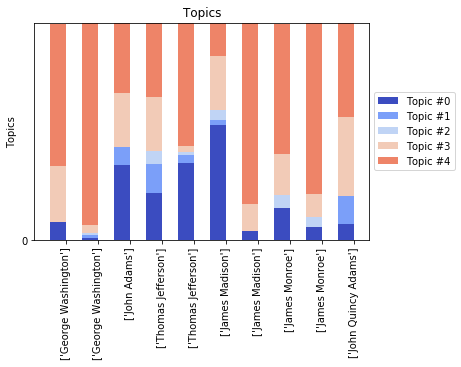

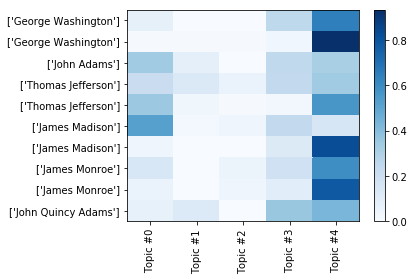

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,people,government,government,people,government
1,nation,nation,nation,government,state
2,state,people,great,nation,power
3,government,state,people,great,people
4,power,great,world,country,shall
5,country,world,new,state,citizen
6,citizen,law,state,world,nation
7,world,right,peace,shall,great
8,new,time,citizen,time,constitution
9,shall,new,shall,power,country


In [65]:
ldaDFVis5, ldaDFVisNames5 = create_subset(ldaDF5, 5)
visualize_stack(lda5, ldaDFVis5, ldaDFVisNames5)
visualize_heatmap(lda5, ldaDFVis5, ldaDFVisNames5)
show_topics(lda5)

Topic modeling at 5 topics does not seem to give us a good idea. This is because there are too many overlapping words in each topic. I will reduce the number of topics to 3 and 2 respectively.

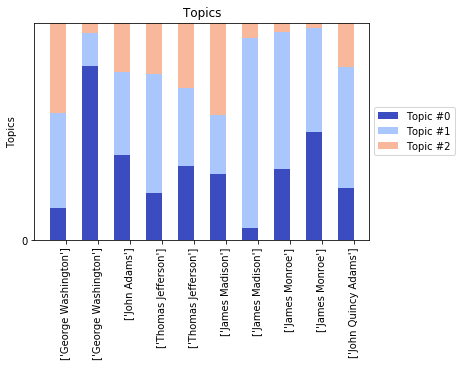

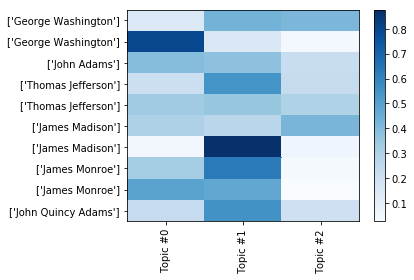

,Topic_0,Topic_1,Topic_2
0,people,government,government
1,government,people,people
2,nation,great,nation
3,state,state,country
4,great,nation,world
5,citizen,power,new
6,world,country,power
7,shall,shall,great
8,country,citizen,state
9,power,peace,time


In [66]:
# 3 topics
lda3, ldaDF3 = fit_LDA(speeches, speechesmm, sp_dictionary, 3, a='auto', h='auto')
ldaDFVis3, ldaDFVisNames3 = create_subset(ldaDF3, 3)
visualize_stack(lda3, ldaDFVis3, ldaDFVisNames3)
visualize_heatmap(lda3, ldaDFVis3, ldaDFVisNames3)
show_topics(lda3)

Even with 3 topics, there are still too many overlapping words. Let's try it again with 2 topics.

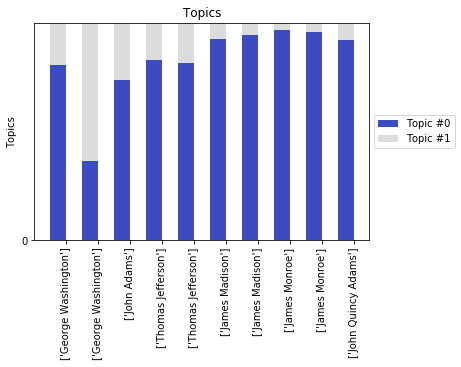

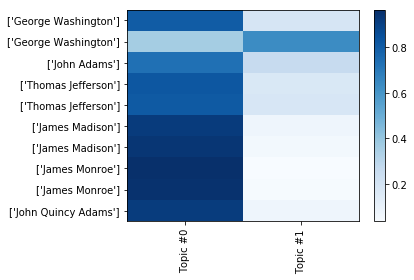

,Topic_0,Topic_1
0,government,people
1,people,nation
2,state,government
3,nation,great
4,great,state
5,country,world
6,world,time
7,power,power
8,shall,citizen
9,peace,country


In [67]:
# 2 topics
lda2, ldaDF2 = fit_LDA(speeches, speechesmm, sp_dictionary, 2, a='auto', h='auto')
ldaDFVis2, ldaDFVisNames2 = create_subset(ldaDF2, 2)
visualize_stack(lda2, ldaDFVis2, ldaDFVisNames2)
visualize_heatmap(lda2, ldaDFVis2, ldaDFVisNames2)
show_topics(lda2)

<Figure size 432x288 with 0 Axes>

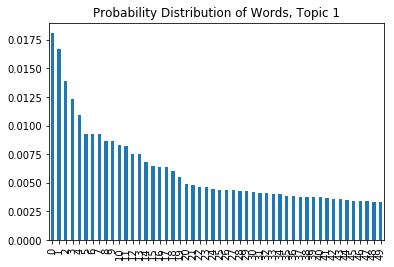

In [68]:
topic1_df = pandas.DataFrame(lda2.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show();

Based on the analysis so far, I am going to settle at 2 as the number of topics. Next, I will vary alpha and eta.

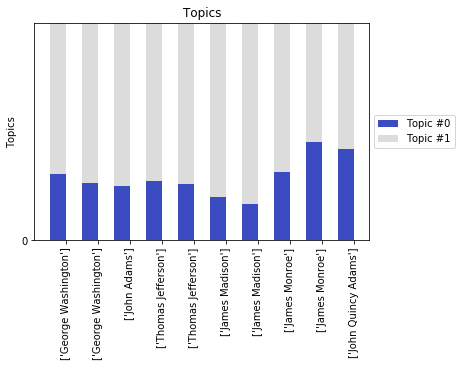

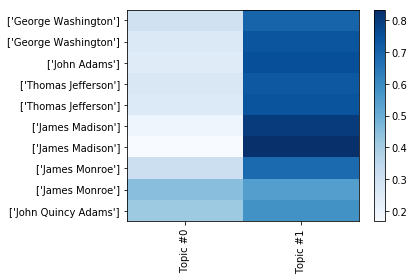

,Topic_0,Topic_1
0,government,people
1,people,government
2,nation,nation
3,great,state
4,state,great
5,country,world
6,power,citizen
7,world,power
8,law,shall
9,shall,country


In [69]:
# 2 topics, alpha = 'asymmetric', eta = 'auto'
lda2_0, ldaDF2_0 = fit_LDA(speeches, speechesmm, sp_dictionary, 2, a='asymmetric', h='auto')
ldaDFVis2_0, ldaDFVisNames2_0 = create_subset(ldaDF2_0, 2)
visualize_stack(lda2_0, ldaDFVis2_0, ldaDFVisNames2_0)
visualize_heatmap(lda2_0, ldaDFVis2_0, ldaDFVisNames2_0)
show_topics(lda2_0)

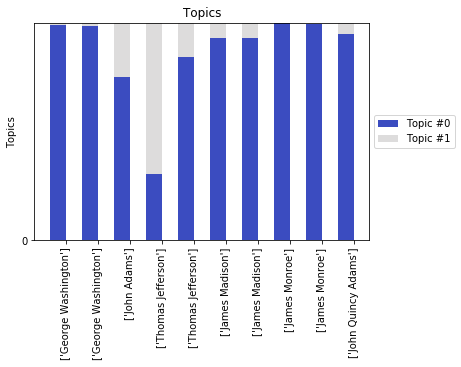

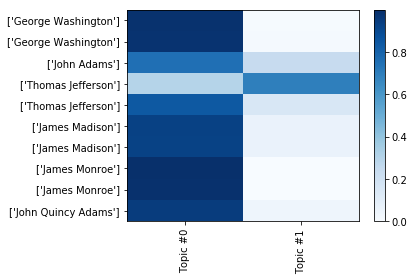

,Topic_0,Topic_1
0,government,government
1,people,people
2,nation,nation
3,great,world
4,state,state
5,power,country
6,country,great
7,citizen,shall
8,world,new
9,shall,man


In [70]:
# 2 topics, alpha = 'asymmetric', eta = 0.00001
lda2_1, ldaDF2_1 = fit_LDA(speeches, speechesmm, sp_dictionary, 2, a='asymmetric', h=0.00001)
ldaDFVis2_1, ldaDFVisNames2_1 = create_subset(ldaDF2_1, 2)
visualize_stack(lda2_1, ldaDFVis2_1, ldaDFVisNames2_1)
visualize_heatmap(lda2_1, ldaDFVis2_1, ldaDFVisNames2_1)
show_topics(lda2_1)

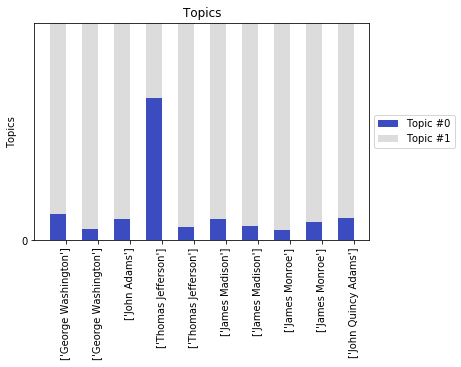

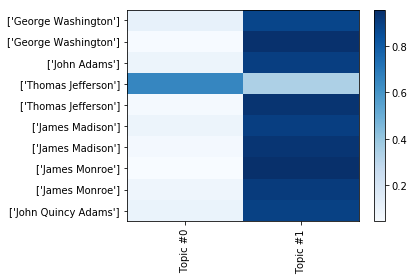

,Topic_0,Topic_1
0,people,government
1,government,people
2,nation,state
3,great,nation
4,world,great
5,country,shall
6,power,power
7,new,citizen
8,state,law
9,man,country


In [71]:
# 2 topics, alpha = 'asymmetric', eta = 0.9
lda2_2, ldaDF2_2 = fit_LDA(speeches, speechesmm, sp_dictionary, 2, a='asymmetric', h=0.9)
ldaDFVis2_2, ldaDFVisNames2_2 = create_subset(ldaDF2_2, 2)
visualize_stack(lda2_2, ldaDFVis2_2, ldaDFVisNames2_2)
visualize_heatmap(lda2_2, ldaDFVis2_2, ldaDFVisNames2_2)
show_topics(lda2_2)

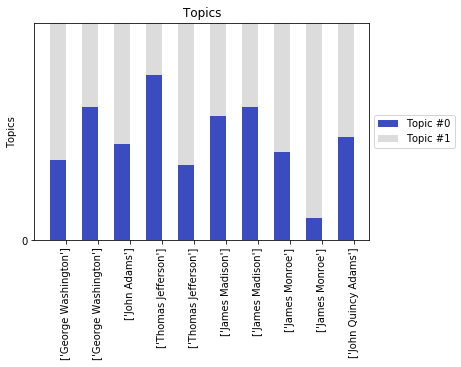

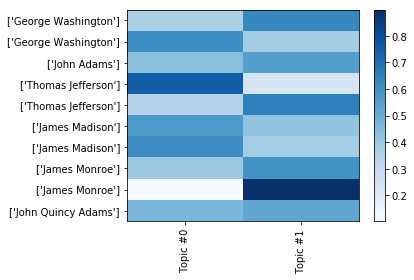

,Topic_0,Topic_1
0,people,government
1,government,people
2,nation,state
3,great,nation
4,world,great
5,country,citizen
6,shall,power
7,man,country
8,state,law
9,power,time


In [72]:
# 2 topics, alpha = 'auto', eta = 0.00001
lda2_3, ldaDF2_3 = fit_LDA(speeches, speechesmm, sp_dictionary, 2, a='auto', h=0.00001)
ldaDFVis2_3, ldaDFVisNames2_3 = create_subset(ldaDF2_3, 2)
visualize_stack(lda2_3, ldaDFVis2_3, ldaDFVisNames2_3)
visualize_heatmap(lda2_3, ldaDFVis2_3, ldaDFVisNames2_3)
show_topics(lda2_3)

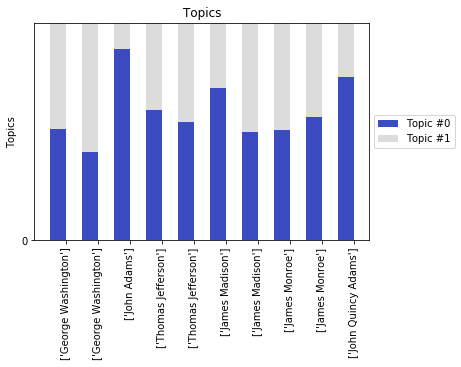

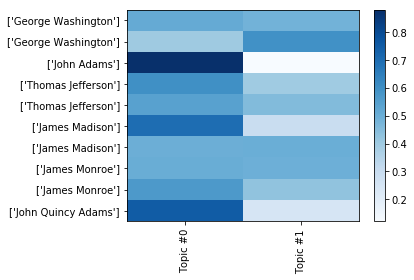

,Topic_0,Topic_1
0,people,government
1,government,state
2,nation,people
3,great,nation
4,country,great
5,state,shall
6,power,world
7,world,citizen
8,citizen,man
9,law,right


In [73]:
# 2 topics, alpha = 'auto', eta = 0.9
lda2_4, ldaDF2_4 = fit_LDA(speeches, speechesmm, sp_dictionary, 2, a='auto', h=0.9)
ldaDFVis2_4, ldaDFVisNames2_4 = create_subset(ldaDF2_4, 2)
visualize_stack(lda2_4, ldaDFVis2_4, ldaDFVisNames2_4)
visualize_heatmap(lda2_4, ldaDFVis2_4, ldaDFVisNames2_4)
show_topics(lda2_4)

__Discussion:__ Varying the parameters significantly changes the topic distribution of each document. For example,  in 2 topics, alpha = 'auto', eta = 0.00001 model, almost all of the subset documents have higher probabilities of topic # 1. However, in 2 topics, alpha = 'asymmetric', eta = 'auto' model, most documents seem to have higher probabilities of topic # 0. 

Regardless of the parameter tuning, one clear pattern is confirmed by topic modeling which comports with our finding from clustering: the inaugural address corpora is not diverse at all. The types of topics are very limited and documents are not so much different from one another. One room for improvement is to get rid of high frequency words such as government, nation, and country to try to see if we can detect more subtle differences between documents.

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [3]:
#corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"
corpora_address = "./data/SOAP"

In [4]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [5]:
import zipfile
import pandas as pd

In [6]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [7]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [8]:
soap_dict = {}

In [9]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [10]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [11]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [12]:
i = 0

In [13]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [14]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [15]:
dool = soap_df['Tokenized Texts'][9]

In [16]:
' '.join(dool[0:1500])

"@!Katherine Any sign of your daddy sweetheart @!Nikki They 'll be here soon @!Katherine They said they 're on their way @!Noah They 're here Daddy 's home @!Nicholas Where 's my boy @!Noah Yea Why are you breathing so funny Daddy @!Nicholas Because I ran all the way here I could n't wait to see you @!Katherine It 's finally over @!Nikki Thank God @!Miguel Congratulations Victoria @!Victoria Thank you Miguel You 're looking at a real hero If it were n't for Ryan Nicholas would n't be here with us @!Katherine You look wonderful Nicholas @!Nicholas I feel wonderful @!Katherine I told you your daddy was coming home @!Noah And you 're never leaving again are you Daddy @!Nicholas That 's right never Oh come on @!Ryan Welcome home Nicholas @!Nicholas Thanks @!Rianna Do n't forget your medication @!Raul No more triple chocolate cake @!Billy Been there done that @!Raul Yeah right @!Billy Hey rough We 're here for you all right @!Raul What 's rough is spending one more minute in this place @!Ri

In [17]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [18]:
import networkx as nx

In [19]:
actor_network = nx.Graph()

In [20]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [21]:
i = 0

In [22]:
all_texts = []

In [23]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


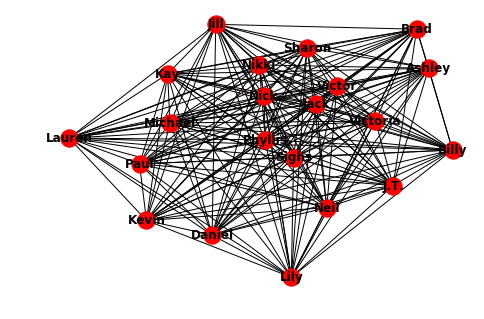

In [24]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [25]:
all_texts[0:10]

[['soon'],
 ['thank', 'god'],
 ['thank', 'miguel', 'look', 'real', 'hero', 'ryan', 'nicholas'],
 [],
 ['hey', 'rough', 'right'],
 ['house'],
 ['right',
  'be',
  'sure',
  'mamie',
  'like',
  'help',
  'look',
  'get',
  'right',
  'glad',
  'get',
  'joint',
  'man'],
 ['yes', 'care', 'boy', 'huh'],
 ['you', 'late'],
 ['yes', 'research', 'find', 'threat', 'husband', 'pose']]

In [26]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [27]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [28]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [29]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [30]:
doollda.show_topics()

[(0,
  '0.227*"yes" + 0.031*"get" + 0.030*"sharon" + 0.020*"fine" + 0.020*"billy" + 0.018*"nick" + 0.017*"baby" + 0.017*"door" + 0.015*"mind" + 0.014*"think"'),
 (1,
  '0.108*"know" + 0.061*"good" + 0.054*"hey" + 0.050*"um" + 0.026*"victor" + 0.025*"hear" + 0.025*"feel" + 0.022*"happen" + 0.019*"thing" + 0.018*"well"'),
 (2,
  '0.090*"thank" + 0.051*"like" + 0.046*"hello" + 0.039*"leave" + 0.027*"stop" + 0.025*"daisy" + 0.020*"son" + 0.019*"believe" + 0.013*"excuse" + 0.012*"huh"'),
 (3,
  '0.105*"want" + 0.035*"talk" + 0.026*"help" + 0.024*"need" + 0.019*"know" + 0.019*"get" + 0.016*"marry" + 0.015*"stay" + 0.014*"away" + 0.014*"long"'),
 (4,
  '0.143*"right" + 0.066*"mean" + 0.027*"find" + 0.021*"mom" + 0.021*"great" + 0.018*"know" + 0.018*"phone" + 0.016*"deal" + 0.015*"go" + 0.014*"hell"'),
 (5,
  '0.104*"na" + 0.102*"gon" + 0.101*"be" + 0.092*"uh" + 0.030*"know" + 0.025*"sorry" + 0.011*"try" + 0.011*"hurt" + 0.010*"kind" + 0.009*"time"'),
 (6,
  '0.059*"go" + 0.057*"think" + 0.054

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [31]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [32]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.09591798), (1, 0.16747765), (2, 0.015863508), (3, 0.07221252), (5, 0.20009632), (6, 0.12337537), (7, 0.24280852), (8, 0.08224628)]
[(0, 0.09861677), (1, 0.16918878), (2, 0.016580237), (3, 0.0729336), (5, 0.2029823), (6, 0.12116247), (7, 0.24398932), (8, 0.07454413)]
[(0, 0.09538479), (1, 0.1689389), (2, 0.015343696), (3, 0.07298954), (5, 0.2032019), (6, 0.121607296), (7, 0.24800283), (8, 0.07452752)]
[(0, 0.09543013), (1, 0.16971904), (2, 0.016940825), (3, 0.070070714), (5, 0.19907963), (6, 0.12386989), (7, 0.25035414), (8, 0.074532144)]
[(0, 0.09510987), (1, 0.1606675), (2, 0.017950902), (3, 0.070924215), (5, 0.20092556), (6, 0.1198739), (7, 0.25279233), (8, 0.081753895)]
[(0, 0.092507884), (1, 0.16526604), (2, 0.016583087), (3, 0.072951294), (5, 0.19927229), (6, 0.12334902), (7, 0.24976477), (8, 0.08030232)]
[(0, 0.09177222), (1, 0.17107128), (2, 0.015258849), (3, 0.07623493), (5, 0.20307715), (6, 0.119922034), (7, 0.24197346), (8, 0.08068768)]
[(0, 0.09632442), (1, 0.16862197

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [33]:
from gensim.matutils import kullback_leibler

In [34]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [35]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

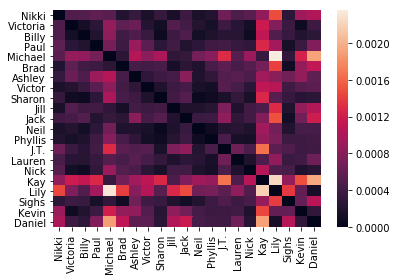

In [36]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [37]:
# corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"
corpora_address = './data/COHA/'

In [38]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [39]:
list(coha_texts.keys())[0:5]

['mag_1940_148025.txt',
 'mag_1940_148026.txt',
 'mag_1940_148027.txt',
 'mag_1940_148028.txt',
 'mag_1940_148029.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [40]:
coha_genres = {}
coha_years = {}

In [41]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [42]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [43]:
coha_years.keys()

dict_keys(['1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1980', '1981', '1982', '1983

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [44]:
import collections

In [45]:
years = []
year_lens = []

In [46]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [47]:
years[0], years[-1]

('1810', '2009')

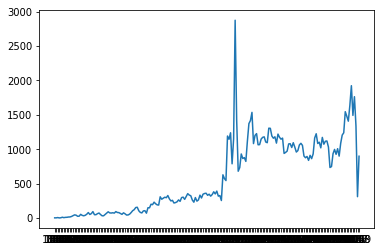

In [48]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [49]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [80]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_timeslice[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_timeslice[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_timeslice[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_timeslice[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_timeslice[4] += len(coha_years[year_info]) - large_files
    i += 1

KeyboardInterrupt: 

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [81]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [82]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [83]:
small_corpus = choose_n(all_texts_coha,  docs_per_timeslice, nums=100)

In [84]:
final_corpus= []

In [85]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [86]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [87]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [88]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [89]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [90]:
from gensim.models import ldaseqmodel

In [91]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

KeyboardInterrupt: 

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
 ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

I am going to fit a dynamic topic models on the inaugural address data set.

In [93]:
speeches.head()

,name,inaug_party,elected,term,inaugural_address,day_of_week,month_day,speech_year,text,clean_text,tokenized_sents,normalized_sents,tokenized_text,normalized_tokens,reduced_tokens
0,George Washington,nonaffiliated,1,1,1,Thursday,April 30,1789,Fellow-Citizens of the Senate and o...,fellow-citizens of the senate and of the house...,"[[fellow, citizens, of, the, senate, and, of, ...","[[fellow, citizen, senate, house, representati...","[fellow, citizens, of, the, senate, and, of, t...","[fellow, citizen, senate, house, representativ...","[fellow, citizen, senate, life, event, great, ..."
1,George Washington,nonaffiliated,1,2,2,Monday,March 4,1793,Fellow Citizens: I AM again cal...,fellow citizens: i am again called upon by th...,"[[fellow, citizens], [i, am, again, called, up...","[[fellow, citizen], [call, voice, country, exe...","[fellow, citizens, i, am, again, called, upon,...","[fellow, citizen, call, voice, country, execut...","[fellow, citizen, voice, country, execute, chi..."
2,John Adams,Federalist,1,1,1,Saturday,March 4,1797,"WHEN it was first perceived, in ...","when it was first perceived, in early times, t...","[[when, it, was, first, perceived, in, early, ...","[[perceive, early, time, middle, course, ameri...","[when, it, was, first, perceived, in, early, t...","[perceive, early, time, middle, course, americ...","[early, time, course, america, remain, foreign..."
3,Thomas Jefferson,Democratic-Republican,1,1,1,Wednesday,March 4,1801,Friends and Fellow-Citizens: CA...,friends and fellow-citizens: called upon to u...,"[[friends, and, fellow, citizens, called, upon...","[[friend, fellow, citizen, call, undertake, du...","[friends, and, fellow, citizens, called, upon,...","[friend, fellow, citizen, call, undertake, dut...","[friend, fellow, citizen, duty, executive, off..."
4,Thomas Jefferson,Democratic-Republican,1,2,2,Monday,March 4,1805,"PROCEEDING, fellow-citizens, to ...","proceeding, fellow-citizens, to that qualifica...","[[proceeding, fellow, citizens, to, that, qual...","[[proceed, fellow, citizen, qualification, con...","[proceeding, fellow, citizens, to, that, quali...","[proceed, fellow, citizen, qualification, cons...","[fellow, citizen, constitution, require, duty,..."


In [96]:
speeches.groupby('speech_year').count()['name']

speech_year
1789    1
1793    1
1797    1
1801    1
1805    1
1809    1
1813    1
1817    1
1821    1
1825    1
1829    1
1833    1
1837    1
1841    1
1845    1
1849    1
1853    1
1857    1
1861    1
1865    1
1869    1
1873    1
1877    1
1881    1
1885    1
1889    1
1893    1
1897    1
1901    1
1905    1
1909    1
1913    1
1917    1
1921    1
1925    1
1929    1
1933    1
1937    1
1941    1
1945    1
1949    1
1953    1
1957    1
1961    1
1965    1
1969    1
1973    1
1977    1
1981    1
1985    1
1989    1
1993    1
1997    1
2001    1
2005    1
2009    1
2013    1
2017    1
Name: name, dtype: int64

In [98]:
# I am going to set the time window based on century
c17 = 3
c18_1 = 12
c18_2 = 13
c19_1 = 12
c19_2 = 13
c20 = 5
print(speeches.shape) # check that length matches
print(c17 + c18_1 + c18_2 + c19_1 + c19_2 + c20)
time_slice = [c17, c18_1, c18_2, c19_1, c19_2, c20]

(58, 15)
58


In [99]:
speech_dlda = ldaseqmodel.LdaSeqModel(corpus=speechesmm, id2word=sp_dictionary, 
                                      time_slice=time_slice,
                                      num_topics=2)

/Users/sanittawan/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [102]:
speech_dlda.print_topic_times(topic=0)

[[('nation', 0.021882277676213653),
  ('world', 0.01807637475895884),
  ('people', 0.017637891144030207),
  ('new', 0.013722355456487768),
  ('man', 0.011931514522139839),
  ('freedom', 0.01137234722635869),
  ('great', 0.011368518142427283),
  ('america', 0.011275354741791456),
  ('government', 0.01071764365548254),
  ('peace', 0.010282893849341869),
  ('time', 0.00937361208069959),
  ('let', 0.009053618031948926),
  ('know', 0.008452531736515525),
  ('life', 0.007783334307578243),
  ('live', 0.0075775074959226005),
  ('work', 0.0075531005585982225),
  ('come', 0.006774326140547192),
  ('god', 0.006747895374749325),
  ('free', 0.006614167489416858),
  ('hope', 0.006592490730779374)],
 [('nation', 0.022013831248913256),
  ('world', 0.01839895238770357),
  ('people', 0.017774803934064783),
  ('new', 0.01388361199192936),
  ('man', 0.011896755625104585),
  ('great', 0.011459197869974175),
  ('freedom', 0.011323670385694472),
  ('america', 0.01122765176932246),
  ('government', 0.01077863

Regarding the first topic, it is simultaneously expected and surprising to see that the majority of the words in the first topic stay very consistent. The main stayers are government, nation, people, peace and god. There are very small amount of words that change. This result suggests that the topics of inaugural addresses stay very consistent across centuries! 

In [101]:
speech_dlda.print_topic_times(topic=1)

[[('government', 0.02231742200773472),
  ('state', 0.019052073186770584),
  ('people', 0.01550852874888232),
  ('power', 0.012513051705496584),
  ('country', 0.012281727299577303),
  ('great', 0.011885295996987011),
  ('citizen', 0.01058624766224385),
  ('shall', 0.009947367786326777),
  ('public', 0.00973604756493659),
  ('constitution', 0.00948824517059662),
  ('law', 0.009345751370925595),
  ('nation', 0.0090994409709799),
  ('union', 0.008360312905235787),
  ('right', 0.008276259587279062),
  ('duty', 0.008203619232179467),
  ('unite', 0.007468375193061),
  ('war', 0.0058878297742037105),
  ('principle', 0.005652592374115343),
  ('time', 0.005234496176486322),
  ('congress', 0.00503551689990292)],
 [('government', 0.022318633155577146),
  ('state', 0.019420365042756158),
  ('people', 0.015593922067259052),
  ('power', 0.01231996406644819),
  ('great', 0.012108795231260915),
  ('country', 0.012082798240454317),
  ('citizen', 0.010198245022281881),
  ('shall', 0.009908881792824639),


Regarding the second topic, even though there are a lot of overlapping words such as government, state, and people, we see a pattern that this topic is more about the administration and institution because we see words such as Congress and constitution appearing consistently. Another main stayer that is interesting is war. It is true that America has fought wars every century. The result of the second topic also suggests that there has not been much evolution in American inaugural addresses.